### Convert images to TFRecords file. 
Refer to https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/how_tos/reading_data/convert_to_records.py

In [1]:
import tensorflow as tf
print tf.__version__

0.12.1


### Convert images to TFRecord file

In [ ]:
from PIL import Image
import numpy as np
import tensorflow as tf
import os

def _int64_feature(value):
  """Wrapper for inserting int64 features into Example proto."""
  if not isinstance(value, list):
    value = [value]
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _bytes_feature(value):
  """Wrapper for inserting bytes features into Example proto."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def main(data_dir, tfrecords_filename):
    labels = os.listdir(data_dir)
    writer = tf.python_io.TFRecordWriter(tfrecords_filename)
    for label in labels:
        path = os.path.join(data_dir, label)
        img_files = os.listdir(path)
        for file in img_files:
            # The reason to store image sizes was demonstrated
            # in the previous example -- we have to know sizes
            # of images to later read raw serialized string,
            # convert to 1d array and convert to respective
            # shape that image used to have.
            img_path = os.path.join(path, file)
            img = np.array(Image.open(img_path))
            height = img.shape[0]
            width = img.shape[1]
            img_raw = img.tostring()

            example = tf.train.Example(features=tf.train.Features(feature={
            'height': _int64_feature(height),
            'width': _int64_feature(width),
            'image_raw': _bytes_feature(img_raw),
            'label': _int64_feature(int(label))}))
            writer.write(example.SerializeToString())
    writer.close()

if __name__ == '__main__':
    data_dir = './tempimg'
    tfrecords_filename = 'validation.tfrecords'
    main(data_dir = data_dir, tfrecords_filename = tfrecords_filename)

### Feed images from TFRecords file randomly
Refer to: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/how_tos/reading_data/fully_connected_reader.py

2 (2, 244, 244, 3) (2,)
current batch


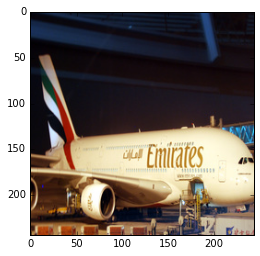

0


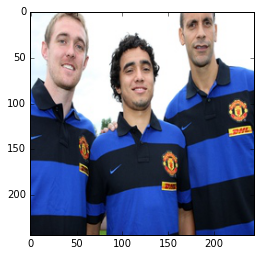

1
current batch


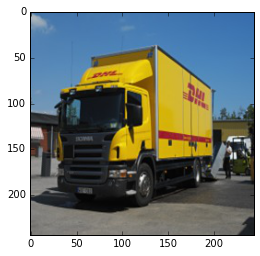

1


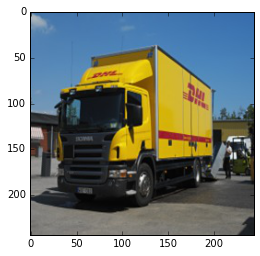

1
current batch


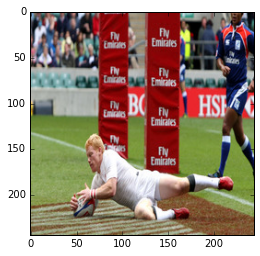

0


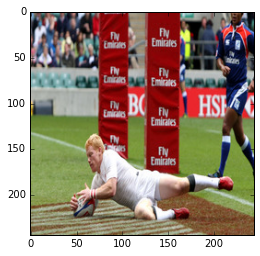

0
current batch


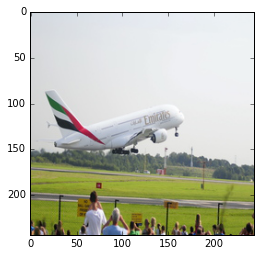

0


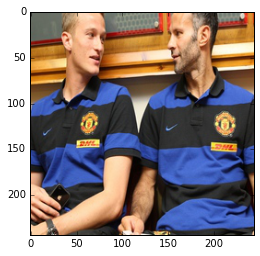

1
current batch


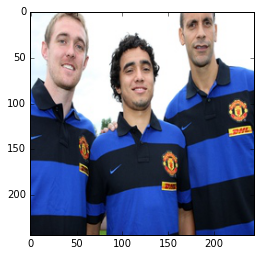

1


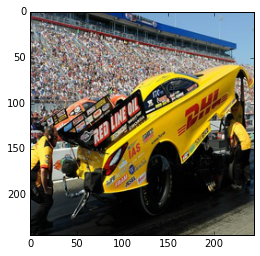

1
current batch


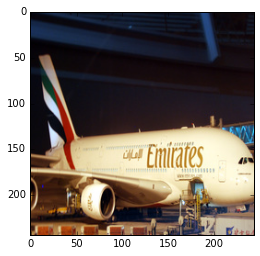

0


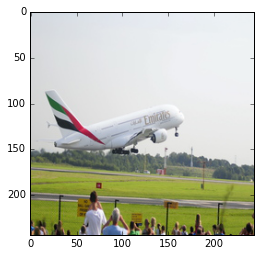

0
current batch


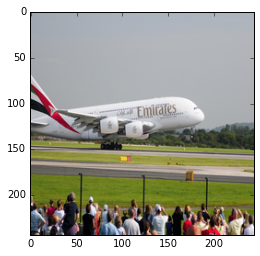

0


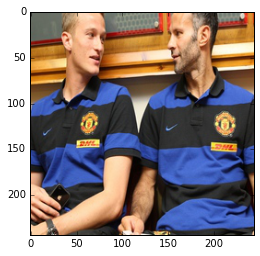

1
current batch


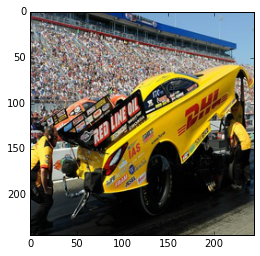

1


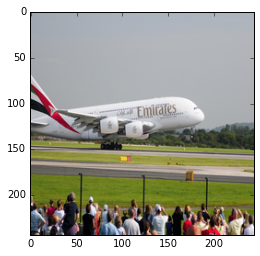

0
Done for 2 epochs


In [15]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
from __future__ import print_function
filename = 'validation.tfrecords'

SIZE = 244

def read_and_decode(filename):
    reader = tf.TFRecordReader()
    _,serialized_example = reader.read(filename)
    features = tf.parse_single_example(serialized_example, 
        features = {
        'height': tf.FixedLenFeature([],tf.int64), 
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64)})
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    label = tf.cast(features['label'], tf.int32)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)

    image_shape = tf.pack([height, width, 3])
    image = tf.reshape(image, image_shape)
    # resize image for the nets
    resized_image = tf.image.resize_image_with_crop_or_pad(image, SIZE, SIZE)
    # resized_image = tf.image.resize_images(resized_image, [SIZE, SIZE],align_corners=True)
    images, labels = tf.train.shuffle_batch([resized_image, label], shapes = [(SIZE,SIZE,3),()],
                                            batch_size = 2, capacity = 300, 
                                            # num_threads=2, 
                                            min_after_dequeue = 10)
    print (2, images.get_shape(), labels.get_shape())
    return images, labels

filename_queue = tf.train.string_input_producer([filename], num_epochs=2)
image, label = read_and_decode(filename_queue)
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    try:
        while not coord.should_stop():
            img, lab = sess.run([image, label])
            # print img[0,:,:,:].get_shape()
            print ('current batch')
            plt.imshow(img[0, :, :, :])

            plt.show()
            print (lab[0])
            plt.imshow(img[1, :, :, :])
            plt.show()
            print (lab[1])
    except tf.errors.OutOfRangeError:
        print('Done for %d epochs'%2)
    finally:
        coord.request_stop()
        coord.join(threads)

## explore image_resizing

2 (2, 244, 244, 3) (2,)
croped image 244x244


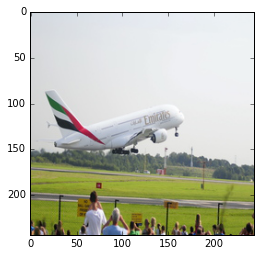

0
resized image 244x244 (size not changed)


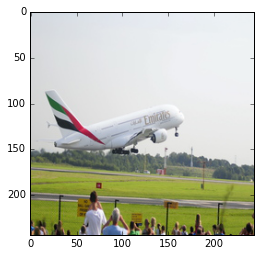

resized image 200x200 (sized changed)


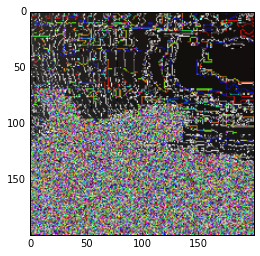

In [27]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
from __future__ import print_function
filename = 'validation.tfrecords'

SIZE = 244

def read_and_decode(filename, size):
    reader = tf.TFRecordReader()
    _,serialized_example = reader.read(filename)
    features = tf.parse_single_example(serialized_example, 
        features = {
        'height': tf.FixedLenFeature([],tf.int64), 
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64)})
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    label = tf.cast(features['label'], tf.int32)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)

    image_shape = tf.pack([height, width, 3])
    image = tf.reshape(image, image_shape)
    # resize image for the nets
    croped_image = tf.image.resize_image_with_crop_or_pad(image, size, size)
#     resized_image = tf.image.resize_images(image, [size, size])
#     resized_images, labels = tf.train.shuffle_batch([resized_image, label], shapes = [(size,size,3),()],
#                                             batch_size = 2, capacity = 300, 
#                                             # num_threads=2, 
#                                             min_after_dequeue = 10)
#     images, labels = tf.train.shuffle_batch([image, label], shapes = [(299,299,3),()],
#                                             batch_size = 2, capacity = 300, 
#                                             # num_threads=2, 
#                                             min_after_dequeue = 10)
    croped_images, labels = tf.train.shuffle_batch([croped_image, label], shapes = [(size,size,3),()],
                                            batch_size = 2, capacity = 300, 
                                            # num_threads=2, 
                                            min_after_dequeue = 10)
    print (2, croped_images.get_shape(), labels.get_shape())
    return croped_images, labels

filename_queue = tf.train.string_input_producer([filename], num_epochs=2)
image, label = read_and_decode(filename_queue, SIZE)

# image size is 244x244, no change here
resized_image_1 = tf.image.resize_images(image, [244, 244])

# resize image to 200x200
resized_image_2 = tf.image.resize_images(image, [200, 200])
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for i in xrange(1):
        resized_img_1, resized_img_2, img, lab = sess.run([resized_image_1, resized_image_2, image, label])
        # print img[0,:,:,:].get_shape()
        print ('croped image 244x244')
        plt.imshow(img[0, :, :, :])
        plt.show()
        print (lab[0])

        print('resized image 244x244 (size not changed)')
        plt.imshow(resized_img_1[0, :, :, :])
        plt.show()
        
        print('resized image 200x200 (sized changed)')
        plt.imshow(resized_img_2[0, :, :, :])
        plt.show()
        
        
        
    coord.request_stop()
    coord.join(threads)

In [65]:
cv2.imwrite('xxx.jpg', resized_img_2[0, :, :, :])

True

As you can see, resized image is messed up, while displaying with plt, if image size is changed.  However, resized image can work in neural network. In tf.summary.image, resized images are shown normally. That is the problem of matplot, if you save the image by cv2 and check that file, you will see a good resized image.

### make a simple network run
working with crop_or_pad image resizing

current batch


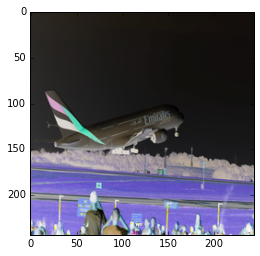

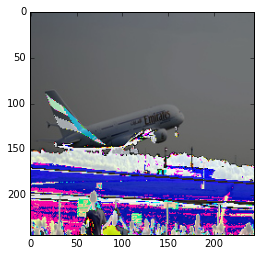

0
current batch


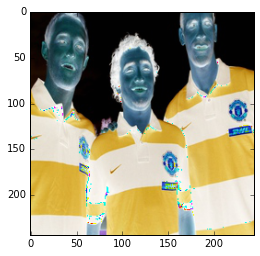

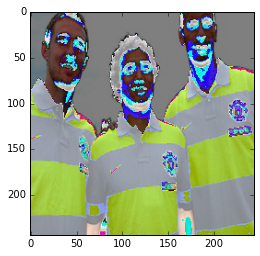

1
current batch


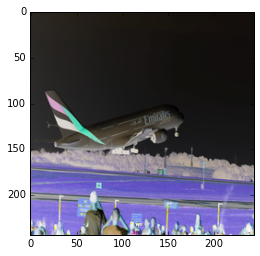

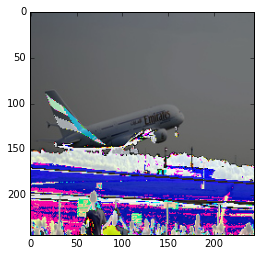

0
current batch


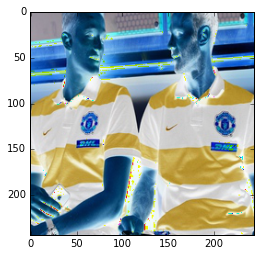

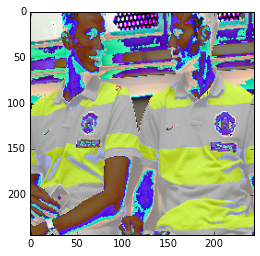

1
current batch


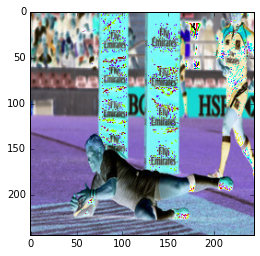

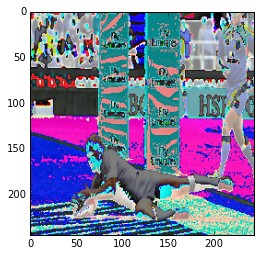

0
current batch


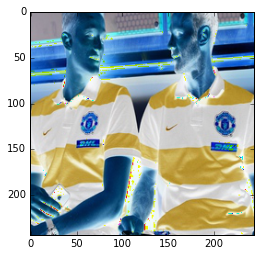

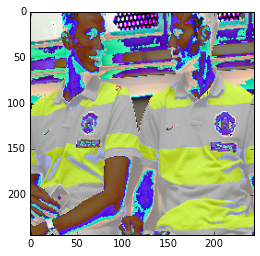

1
current batch


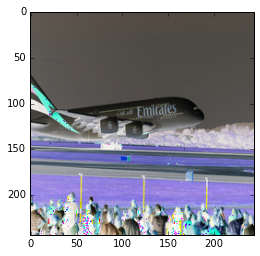

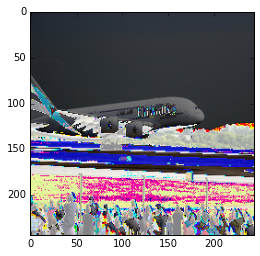

0
current batch


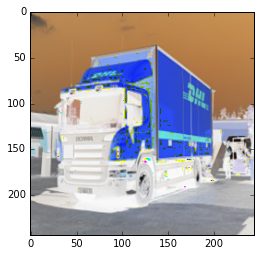

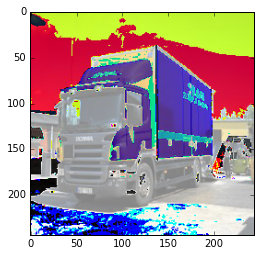

1
Done for 2 epochs


In [66]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
from __future__ import print_function
filename = 'validation.tfrecords'

SIZE = 244

def read_and_decode(filename):
    reader = tf.TFRecordReader()
    _,serialized_example = reader.read(filename)
    features = tf.parse_single_example(serialized_example, 
        features = {
        'height': tf.FixedLenFeature([],tf.int64), 
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64)})distorted
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    label = tf.cast(features['label'], tf.int32)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)

    image_shape = tf.pack([height, width, 3])
    image = tf.reshape(image, image_shape)
    # resize image for the nets
    resized_image = tf.image.resize_image_with_crop_or_pad(image, SIZE, SIZE)
    resized_image = tf.cast(resized_image, tf.float32) * (1. / 255) - 0.5
    # resized_image = tf.image.resize_images(resized_image, [SIZE, SIZE],align_corners=True)
    return resized_image, label

def inputs():
    filename = 'validation.tfrecords'
    filename_queue = tf.train.string_input_producer([filename], num_epochs=2)
    image, label = read_and_decode(filename_queue)
    images, labels = tf.train.shuffle_batch([image, label], shapes = [(SIZE,SIZE,3),()],
                                            batch_size = 2, capacity = 300, 
                                            # num_threads=2, 
                                            min_after_dequeue = 10)
    return images, labels
    

def inference (inputs, num_classes):
#     full = 'tensorflow.contrib.slim.python.slim.nets.' + 'vgg.vgg_16'
#     # e.g. full == 'tensorflow.contrib.slim.python.slim.nets.vgg.vgg_a'
#     fs = full.split('.')
#     loader = pkgutil.find_loader('.'.join(fs[:-1]))
#     module = loader.load_module('')
#     net = getattr(module, fs[-1])
    return net.vgg.vgg_16(inputs, num_classes)

def fcn_loss (logits, labels):
    with tf.name_scope('loss'):
        labels = tf.to_int32(labels)    # float from picpac
        xe = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits, name='xentropy')
        hit = tf.cast(tf.nn.in_top_k(logits, labels, 1, name="accuracy"), tf.float32)
        return [tf.reduce_mean(xe, name='xentropy_mean'), tf.reduce_mean(hit, name='accuracy_total')]
    pass

with tf.Graph().as_default():
    # Input images and labels.
    images, labels = inputs()
    predictions, _ = inference(images, FLAGS.num_classes)
    loss, accurate = fcn_loss(predictions, labels)

    # Specify the optimization scheme:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=FLAGS.learning_rate)
    # create_train_op that ensures that when we evaluate it to get the loss,
    # the update_ops are done and the gradient updates are computed.
    # train_op = slim.learning.create_train_op(loss, optimizer)
    train_op = optimizer.minimize(loss)
    init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())
    with tf.Session() as sess:
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        try:
            while not coord.should_stop():
                img, lab = sess.run([images, labels])
                # print img[0,:,:,:].get_shape()
#                 print ('current batch')
#                 plt.imshow((img[0, :, :, :]+0.5)*255)
#                 plt.show()
#                 plt.imshow(img[0,:,:,:])
#                 plt.show()
#                 print (lab[0])
        except tf.errors.OutOfRangeError:
            print('Done for %d epochs'%2)
        finally:
            coord.request_stop()
            coord.join(threads)